# Feature selection

Применение различных методов по отбору признаков

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

## Сгенерируем данные

In [2]:
x_data_generated, y_data_generated = make_classification(scale=1.0)

In [3]:
features_df = pd.DataFrame(x_data_generated)

In [4]:
features_df.shape

(100, 20)

In [5]:
target_df = pd.DataFrame(y_data_generated, columns=['target'])

In [6]:
target = target_df['target']

Сформируем dataframe для удобства:

In [7]:
df = pd.concat([features_df, target_df], axis=1)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,-0.810581,0.929636,1.136525,-0.811868,0.418594,0.196073,0.365736,-0.758116,-0.245041,-0.825836,...,0.532955,-0.301082,0.859577,-0.604208,0.828495,-0.209802,-1.171191,0.485574,-0.687079,1
1,-1.809789,-0.085897,1.431917,-0.253467,-0.920656,-0.088732,1.149183,-1.077149,1.427335,0.344324,...,-0.497920,-0.247362,-1.988598,2.006185,-0.342564,1.670207,-1.784541,0.683636,0.949450,1
2,0.334827,0.914949,1.851146,-0.308023,0.680477,-0.060114,-2.400992,-0.041241,-0.113625,0.035196,...,0.760807,-0.114288,-1.309300,0.358113,0.588365,-0.775370,1.595872,-0.275381,-0.096273,0
3,1.723295,0.120713,-0.076419,-0.789411,-0.226036,-0.280883,1.120217,-0.755048,-0.217217,0.904926,...,-0.388938,-1.532657,-0.783057,0.993566,-0.815353,1.054173,0.582957,0.625885,-0.170237,0
4,-0.755964,-1.047965,-0.157662,0.785226,-0.609117,0.013388,0.863951,-0.586469,0.999998,0.529836,...,0.548764,0.088995,-0.724331,0.866532,2.818173,0.872827,-0.116219,0.851478,1.615125,1


In [9]:
df.shape

(100, 21)

Подготовим список для хранения промежуточных результатов:

In [10]:
results = []

## Построим модель логистической регрессии и оценим её точность

In [11]:
score = cross_val_score(LogisticRegression(), features_df, target, scoring='accuracy').mean()
print(score)

0.8099999999999999


Добавим промежуточные результаты в results:

In [12]:
results.append({
    'feature_selection_method': 'no',
    'features_count': len(features_df.columns),
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81


## Используем статистические методы для отбора признаков

### Выберем признаки на основе матрицы корреляции

In [13]:
corr_matrix = df.corr()

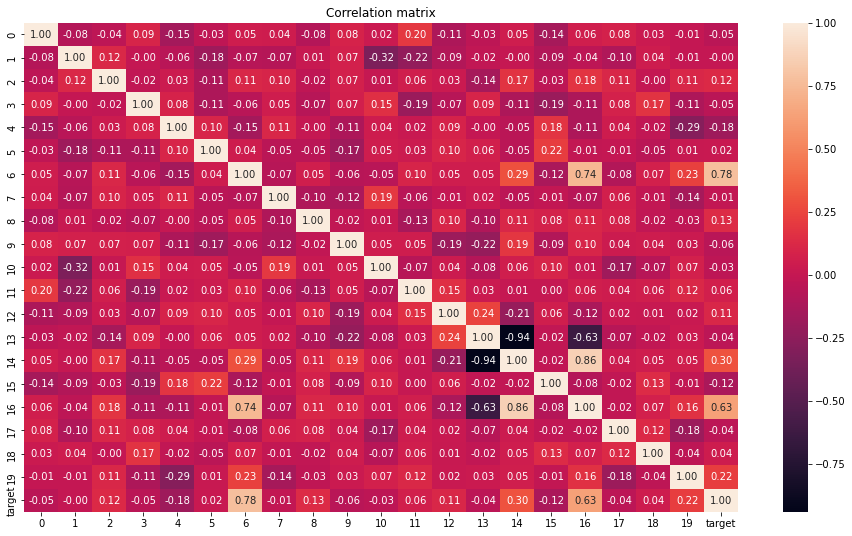

In [14]:
plt.figure(figsize=(16, 9))
plt.title("Correlation matrix")
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

Выберем стобцы у которых корреляция с таргетом превышает 0.3 в абсолютном значении:

In [15]:
columns = corr_matrix[((corr_matrix['target'].abs() >= 0.3) & (corr_matrix.index != 'target'))].index

In [16]:
list(columns)

[6, 14, 16]

In [17]:
score = cross_val_score(LogisticRegression(), df[columns], target, scoring='accuracy').mean()
print(score)

0.9199999999999999


In [18]:
results.append({
    'feature_selection_method': 'correlation matrix',
    'features_count': len(columns),
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92


### Отсечем низковариативные признаки

In [19]:
selector  = VarianceThreshold(threshold=1.2)
X_new = selector.fit_transform(df, y_data_generated)

In [20]:
selector.get_support()

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False])

Удалим столбцы с низковариативными признаками:

In [21]:
columns = [column for column, value in enumerate(selector.get_support()) if value]
columns

[6, 13, 14]

In [22]:
score = cross_val_score(LogisticRegression(), df[columns], target, scoring='accuracy').mean()
print(score)

0.9199999999999999


In [23]:
results.append({
    'feature_selection_method': 'low variance threshold removing',
    'features_count': len(columns),
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92
2,low variance threshold removing,3,0.92


## Отбор признаков на основе дисперсионного анализа

Выберем топ 5 признаков:

In [24]:
X_new = SelectKBest(f_classif, k=5).fit_transform(features_df, target)

In [25]:
score = cross_val_score(LogisticRegression(), X_new, target, scoring='accuracy').mean()
print(score)

0.9099999999999999


In [26]:
results.append({
    'feature_selection_method': 'select k best',
    'features_count': X_new.shape[1],
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92
2,low variance threshold removing,3,0.92
3,select k best,5,0.91


## Отбор с использованием моделей

### Отбор признаков с помощью логистической регрессии

Будем использовать L1 регуляризацию

In [27]:
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear')).fit(features_df, target)

In [28]:
columns = [column for column, value in enumerate(selector.get_support()) if value]
columns

[0, 2, 3, 4, 6, 7, 8, 12, 16, 17]

In [29]:
score = cross_val_score(LogisticRegression(), df[columns], target, scoring='accuracy').mean()
print(score)

0.86


In [30]:
results.append({
    'feature_selection_method': 'select from model (logistic regression)',
    'features_count': len(columns),
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92
2,low variance threshold removing,3,0.92
3,select k best,5,0.91
4,select from model (logistic regression),10,0.86


### Отбор признаков с помощью модели RandomForest

Пусть глубина дерева будет равна 5

In [31]:
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [32]:
clf.fit(features_df, target)

RandomForestClassifier(max_depth=5, random_state=0)

In [33]:
clf.feature_importances_

array([0.0314319 , 0.01898369, 0.0248754 , 0.02421221, 0.03467671,
       0.01494873, 0.33989057, 0.02003821, 0.02731339, 0.03282345,
       0.02146498, 0.02990873, 0.02507921, 0.03015189, 0.06023692,
       0.01812843, 0.14816042, 0.0229931 , 0.02928327, 0.04539879])

Пусть значение feature_importance, ниже которого столбец будет отброшен, будет равно 0.02

In [34]:
columns = [column for column, value in enumerate(clf.feature_importances_) if value >= 0.02]
columns

[0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19]

In [35]:
score = cross_val_score(LogisticRegression(), df[columns], target, scoring='accuracy').mean()
print(score)

0.8400000000000001


In [36]:
results.append({
    'feature_selection_method': 'random forest feature importances',
    'features_count': len(columns),
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92
2,low variance threshold removing,3,0.92
3,select k best,5,0.91
4,select from model (logistic regression),10,0.86
5,random forest feature importances,17,0.84


## Отбор с использованием перебора

In [37]:
selector = SequentialFeatureSelector(estimator=LogisticRegression(penalty='l1', solver='liblinear')).fit(features_df, target)

In [38]:
columns = [column for column, value in enumerate(selector.get_support()) if value]
columns

[0, 1, 2, 3, 5, 6, 8, 9, 10, 13]

In [39]:
score = cross_val_score(LogisticRegression(), df[columns], target, scoring='accuracy').mean()
print(score)

0.89


In [40]:
results.append({
    'feature_selection_method': 'sequential feature selector (logistic regression)',
    'features_count': len(columns),
    'cross_val_score': score
})
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92
2,low variance threshold removing,3,0.92
3,select k best,5,0.91
4,select from model (logistic regression),10,0.86
5,random forest feature importances,17,0.84
6,sequential feature selector (logistic regression),10,0.89


## Выводы

В работы были применены различные методы отбора признаков (features):
* Статистические методы
    * На основе матрицы корреляции
    * Отсечение низковариативных признаков (VarianceThreshold)
* Метод на основе дисперсионного анализа (SelectKBest)
* Метод на основе использования моделей
    * Логистическая регрессия (SelectFromModel(LogisticRegression))
    * Случайный лес (RandomForestClassifier)
* Последовательный перебор признаков (SequentialFeatureSelector)

Сравнительная таблица результатов:

In [41]:
pd.DataFrame(results)

,feature_selection_method,features_count,cross_val_score
0,no,20,0.81
1,correlation matrix,3,0.92
2,low variance threshold removing,3,0.92
3,select k best,5,0.91
4,select from model (logistic regression),10,0.86
5,random forest feature importances,17,0.84
6,sequential feature selector (logistic regression),10,0.89


На основании таблицы результатов можно сделать выводы:
* Не все features обязательно нужны, некоторые наоборот создают шум, и их нужно удалять
* Даже на 3 признаках модель дает качество выше, чем модель построенная на всех 20 признаках